In [1]:
import os
import kagglehub

import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from typing import List, Tuple

/mnt/nfs/home/vujasino/jupyter_workspace/Audits/merlin/.pixi/envs/default/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Downloading data

In [2]:
path = kagglehub.dataset_download("uciml/adult-census-income")
out_path = "../data/adult-census-income"
%rm -r $out_path
%mv $path $out_path

100%|██████████| 450k/450k [00:00<00:00, 1.53MB/s]

Extracting files...


## Data Loading and Analysis

Excerpt from a reference paper "We use age, years of education, capital gain, capital loss, hours-per-week, etc., as continuous features, and education level, gender, etc., as categorical features."

In [3]:
data_path = os.path.join(out_path, "adult.csv")
adult_df = pd.read_csv(data_path)
adult_df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [4]:
continuous_cols = ["age", "education.num", "capital.gain", "capital.loss", "hours.per.week"]
categorical_cols = ["education", "sex"]

### Data Analysis

#### NaN presence analysis

In [5]:
print("NaNs per continuous column:")
dict(zip(continuous_cols, adult_df[continuous_cols].isna().sum(axis=0)))

NaNs per continuous column:


{'age': 0,
 'education.num': 0,
 'capital.gain': 0,
 'capital.loss': 0,
 'hours.per.week': 0}

In [6]:
for col in categorical_cols:
    print(f"{col} values:", adult_df[col].unique())

education values: ['HS-grad' 'Some-college' '7th-8th' '10th' 'Doctorate' 'Prof-school'
 'Bachelors' 'Masters' '11th' 'Assoc-acdm' 'Assoc-voc' '1st-4th' '5th-6th'
 '12th' '9th' 'Preschool']
sex values: ['Female' 'Male']


#### Distributions

In [7]:
def get_approx_subplots_square(n: int) -> Tuple[int, int]:
    """
    Calculate the approximate number of rows and columns for subplots to form close to a square layout.

    Args:
        n (int): The total number of subplots.

    Returns:
        Tuple[int, int]: A tuple containing the number of rows and columns.
    """
    nrows = np.floor(np.sqrt(n)).astype(int)
    ncols = np.ceil(n / nrows).astype(int)
    return nrows, ncols

def square_subplots_prep(n: int, *args, **kwargs) -> Tuple[plt.Figure, np.ndarray]:
    """
    Prepare a square grid of subplots and return the figure and axes.

    This function creates a grid of subplots that is as close to square as possible,
    given the number of subplots `n`. It removes any unused subplots and flattens
    the axes array to return only the used subplots.

    Parameters:
    -----------
    n : int
        The number of subplots to create.
    *args : tuple
        Additional positional arguments to pass to `plt.subplots`.
    **kwargs : dict
        Additional keyword arguments to pass to `plt.subplots`.

    Returns:
    --------
    Tuple[plt.Figure, np.ndarray]
        A tuple containing the figure and an array of the used axes.
    """
    nrows, ncols = get_approx_subplots_square(n)
    fig, axs = plt.subplots(nrows, ncols, *args, **kwargs)
    # Remove unused subplots and flatten the axes array
    for ax in axs.reshape(-1)[n:]:
        fig.delaxes(ax)
    axs = axs.reshape(-1)[:n]
    return fig, axs

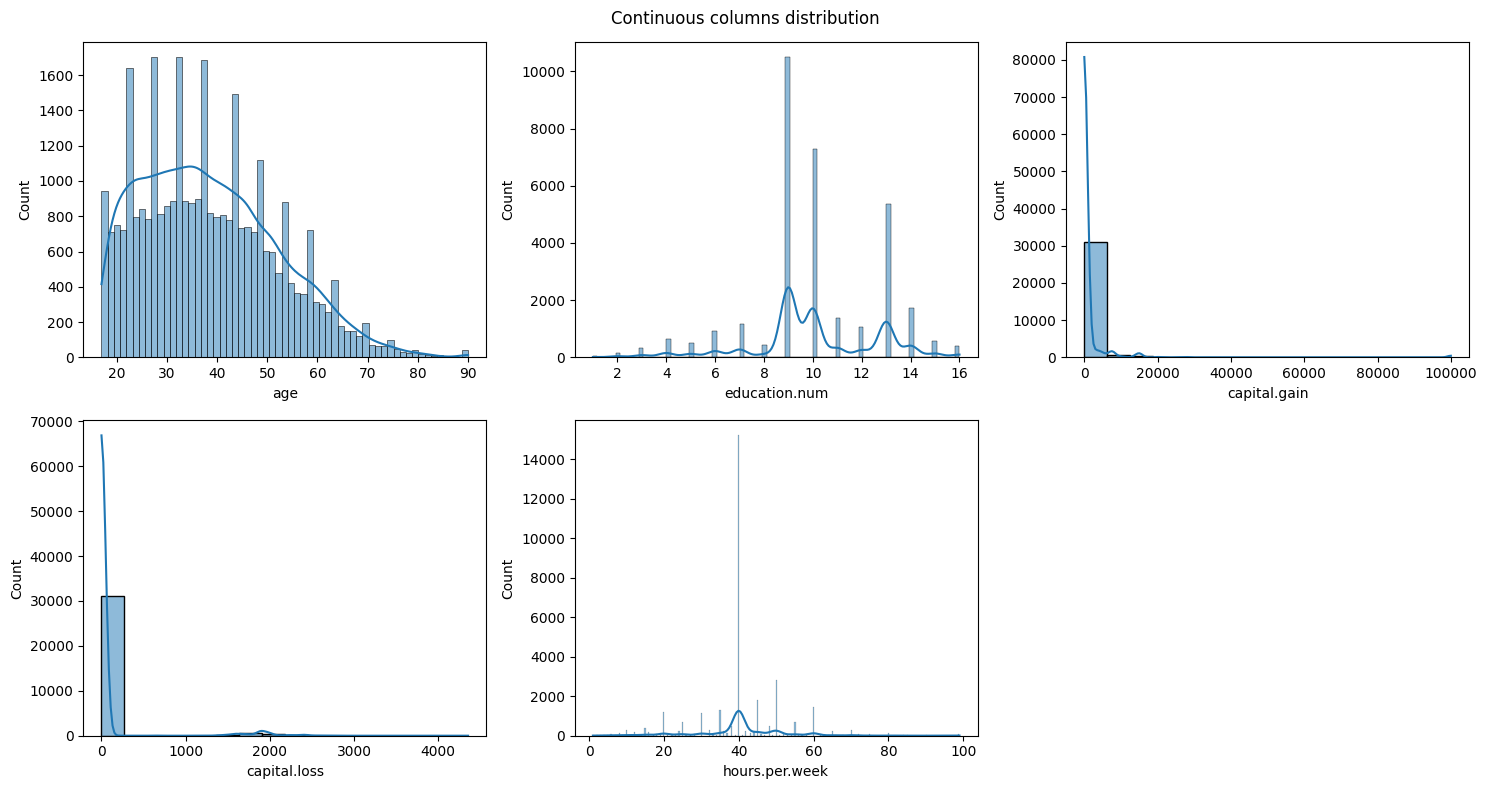

In [8]:
cols_to_plot = continuous_cols
fig, axs = square_subplots_prep(len(cols_to_plot), figsize=(15, 8))

for ax, col in zip(axs, cols_to_plot):
    sns.histplot(adult_df[col], kde=True, ax=ax)

fig.suptitle("Continuous columns distribution")
plt.tight_layout()
plt.show()

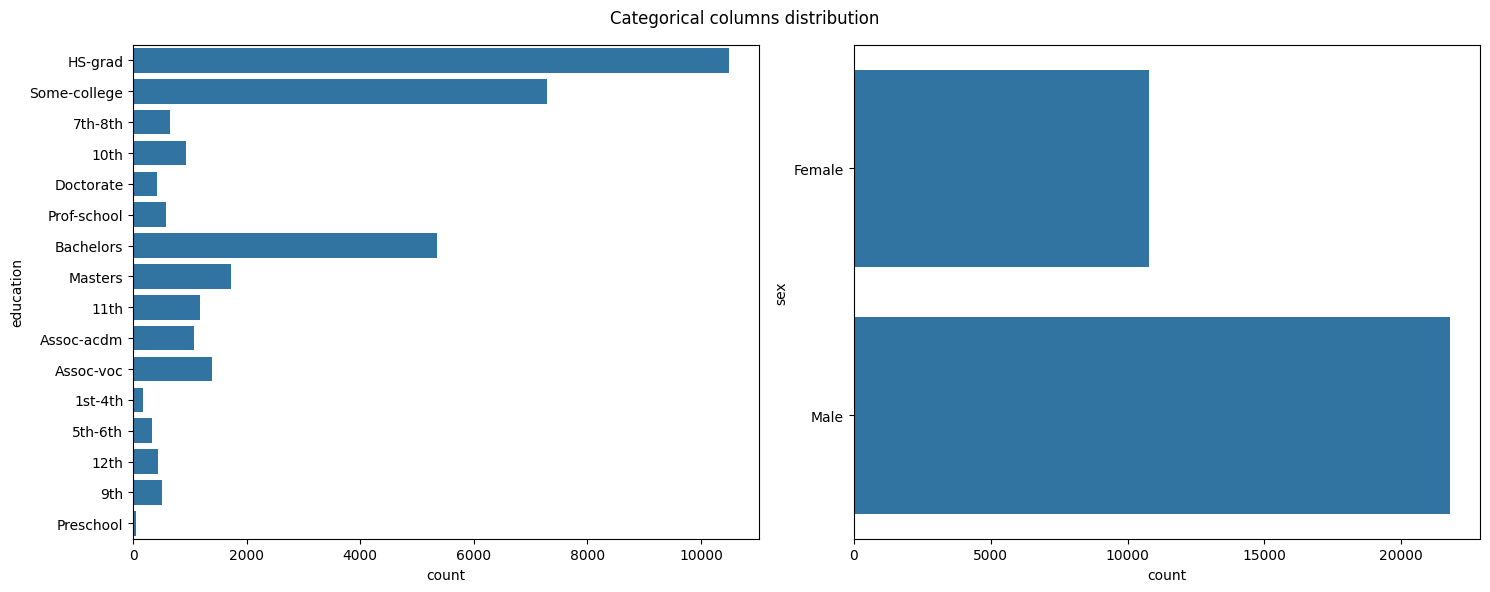

In [9]:
cols_to_plot = categorical_cols
fig, axs = square_subplots_prep(len(cols_to_plot), figsize=(15, 6))

for ax, col in zip(axs, cols_to_plot):
    sns.countplot(adult_df[col], ax=ax)

fig.suptitle("Categorical columns distribution")
plt.tight_layout()
plt.show()

### Processing Data

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
adult_df_X = adult_df[continuous_cols + categorical_cols]
adult_df_y = adult_df["income"]

In [12]:
fairly_normal_continuous_cols = ["age", "education.num", "hours.per.week"]

def create_pipeline(train_X_df: pd.DataFrame, train_y_series: pd.Series) -> dict:
    global continuous_cols, categorical_cols, fairly_normal_continuous_cols
    categorical_encoder = OneHotEncoder(drop="if_binary", sparse_output=False).fit(train_X_df[categorical_cols])
    y_encoder = OneHotEncoder(drop="if_binary", sparse_output=False).fit(train_y_series.to_frame())
    normal_dist_scaler = StandardScaler().fit(train_X_df[continuous_cols])
    return {
        "categorical_encoder": categorical_encoder,
        "y_encoder": y_encoder,
        "normal_dist_scaler": normal_dist_scaler
    }
    
def process_data(X_df: pd.DataFrame, y_series: pd.Series, pipeline: dict):
    global continuous_cols, categorical_cols, fairly_normal_continuous_cols
    X_df = X_df.copy()
    categorical_cols_encodings = pipeline["categorical_encoder"].transform(X_df[categorical_cols])
    X = np.concatenate([
        pipeline["normal_dist_scaler"].transform(X_df[continuous_cols]),
        categorical_cols_encodings
    ], axis=1)
    y = pipeline["y_encoder"].transform(y_series.to_frame()).reshape((-1,))
    sensitive_col = X_df["sex"] == "Female"
    return X, y, sensitive_col

adult_df_X_train_df, adult_df_X_test_df, adult_df_y_train_df, adult_df_y_test_df = train_test_split(
    adult_df_X, adult_df_y, test_size=0.2, random_state=42, stratify=adult_df_X["sex"])
pipeline = create_pipeline(adult_df_X_train_df, adult_df_y_train_df)
adult_X_train, adult_y_train, sensitive_col_train = process_data(adult_df_X_train_df, adult_df_y_train_df, pipeline)
adult_X_test, adult_y_test, sensitive_col_test = process_data(adult_df_X_test_df, adult_df_y_test_df, pipeline)
adult_X_train, adult_y_train, sensitive_col_train

(array([[-1.43207985, -0.03434848, -0.14725877, ...,  0.        ,
          1.        ,  0.        ],
        [-0.62747303, -0.42250869, -0.14725877, ...,  0.        ,
          0.        ,  1.        ],
        [-0.33488872, -0.42250869, -0.14725877, ...,  0.        ,
          0.        ,  1.        ],
        ...,
        [-0.55432695, -0.42250869, -0.14725877, ...,  0.        ,
          0.        ,  1.        ],
        [-1.06634948,  1.13013214, -0.14725877, ...,  0.        ,
          0.        ,  1.        ],
        [-1.13949555, -0.42250869, -0.14725877, ...,  0.        ,
          0.        ,  0.        ]]),
 array([0., 1., 0., ..., 0., 0., 0.]),
 30125     True
 27726    False
 17488    False
 18353    False
 2951     False
          ...  
 1647     False
 14550    False
 20233    False
 12612    False
 22520     True
 Name: sex, Length: 26048, dtype: bool)

In [13]:
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression(max_iter=1000).fit(adult_X_train, adult_y_train)

In [14]:
print("Accuracy:", logistic_regression.score(adult_X_test, adult_y_test))

Accuracy: 0.8203592814371258


In [15]:
senstive_test_X, sensitive_test_y = adult_X_test[sensitive_col_test], adult_y_test[sensitive_col_test]
non_senstive_test_X, non_sensitive_test_y = adult_X_test[~sensitive_col_test], adult_y_test[~sensitive_col_test]

In [16]:
from sklearn import clone
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.exceptions import NotFittedError
from fairlearn.postprocessing import ThresholdOptimizer

class LogisticRegressionAsRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, logistic_regression_estimator):
        self.logistic_regression_estimator = logistic_regression_estimator

    def fit(self, X, y):
        try:
            check_is_fitted(self.logistic_regression_estimator)
            self.logistic_regression_estimator_ = self.logistic_regression_estimator
        except NotFittedError:
            self.logistic_regression_estimator_ = clone(
                self.logistic_regression_estimator
            ).fit(X, y)
        return self

    def predict(self, X):
        # use predict_proba to get real values instead of 0/1, select only prob for 1
        scores = self.logistic_regression_estimator_.predict_proba(X)[:, 1]
        return scores

estimator_wrapper = LogisticRegressionAsRegression(logistic_regression).fit(adult_X_train, adult_y_train)
postprocessed_predictor_EO = ThresholdOptimizer(
    estimator=estimator_wrapper, constraints="equalized_odds", prefit=True
)
postprocessed_predictor_EO.fit(adult_X_train, adult_y_train, sensitive_features=sensitive_col_train)

ThresholdOptimizer(constraints='equalized_odds',
                   estimator=LogisticRegressionAsRegression(logistic_regression_estimator=LogisticRegression(max_iter=1000)),
                   prefit=True)

In [17]:
print("BASE ESTIMATOR:")

print("Accuracy on sensitive data:", 
      estimator_wrapper.logistic_regression_estimator_.score(adult_X_test[sensitive_col_test], adult_y_test[sensitive_col_test]))
print("Accuracy on non-sensitive data:",
      estimator_wrapper.logistic_regression_estimator_.score(adult_X_test[~sensitive_col_test], adult_y_test[~sensitive_col_test]))

print("=" * 80)

y_col_to_show = 1
y_col_val = pipeline["y_encoder"].categories_[0][y_col_to_show]


print(f"P(income{y_col_val} | female) =",
      (estimator_wrapper.logistic_regression_estimator_.predict(adult_X_test[sensitive_col_test]) == y_col_to_show).mean())
print(f"P(income{y_col_val} | male) =",
      (estimator_wrapper.logistic_regression_estimator_.predict(adult_X_test[~sensitive_col_test]) == y_col_to_show).mean())

BASE ESTIMATOR:
Accuracy on sensitive data: 0.9080779944289693
Accuracy on non-sensitive data: 0.7770130763936682
P(income>50K | female) = 0.03714020427112349
P(income>50K | male) = 0.19385180087175957


In [18]:
fair_y_test_predictions = postprocessed_predictor_EO.predict(adult_X_test, sensitive_features=sensitive_col_test)

correct_prediction = (fair_y_test_predictions == adult_y_test)
print("Fair model accuracy:", correct_prediction.mean())

Fair model accuracy: 0.8060801473975127


In [19]:
print("Fair model accuracy on sensitive data:",
      correct_prediction[sensitive_col_test].mean())
print("Fair model accuracy on non-sensitive data:",
      correct_prediction[~sensitive_col_test].mean())

Fair model accuracy on sensitive data: 0.8890436397400185
Fair model accuracy on non-sensitive data: 0.76508373480156


In [20]:
fair_y_test_predictions[sensitive_col_test].mean(), fair_y_test_predictions[~sensitive_col_test].mean()

(np.float64(0.07474466109563603), np.float64(0.12869924294562973))

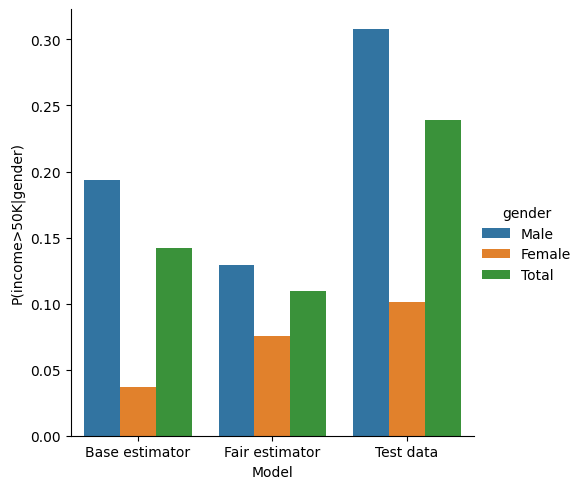

In [21]:
result_list = []

for i, y_col_val in enumerate(pipeline["y_encoder"].categories_[0]):
    for model_name, model in zip(["Base estimator", "Fair estimator", "Test data"], [estimator_wrapper.logistic_regression_estimator_, postprocessed_predictor_EO, None]):
        for gender_name, mask in zip(["Male", "Female", "Total"], [~sensitive_col_test, sensitive_col_test, np.ones_like(sensitive_col_test)]):
            y_col_name = f"income{y_col_val}"
            if model is None:
                predictions = adult_y_test
            elif isinstance(model, ThresholdOptimizer):
                predictions = model.predict(adult_X_test, sensitive_features=sensitive_col_test)
            else:
                predictions = model.predict(adult_X_test)
            result_list.append({
                "model": model_name,
                "target_col": y_col_name,
                "gender": gender_name,
                "mean_proba": (predictions[mask] == i).mean()
            })
    
result_df = pd.DataFrame(result_list)
# print(result_df)

val_to_show = "income>50K"
sns.catplot(data=result_df[result_df["target_col"] == val_to_show], x="model", y="mean_proba", hue="gender", kind="bar")
plt.xlabel("Model")
plt.ylabel(f"P({val_to_show}|gender)")
plt.show()

# CelebA

In [22]:
# celeba_path = "../data/celeba-dataset"
# if not os.path.exists(celeba_path):
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")
# %mv $path $celeba_path

In [23]:
celeba_path = path

In [24]:
import torch
import wandb
import torchvision
import sklearn.model_selection
import torchvision.transforms as transforms

from torchvision.datasets.folder import default_loader
from torch.utils.data import Dataset

from typing import Optional, Callable, Any

In [25]:
celeba_df = pd.read_csv(os.path.join(celeba_path, "list_attr_celeba.csv"))
for column in celeba_df.columns:
    if set(celeba_df[column].unique()) == {1, -1}:
        celeba_df[column] = celeba_df[column].replace(-1, 0)
celeba_sensitive_col = "Male"
celeba_outcome_col = "Blond_Hair"
celeba_strata_idx = 2 * celeba_df[celeba_outcome_col] + celeba_df[celeba_sensitive_col]
celeba_df["strata_id"] = celeba_strata_idx
print("Strata ratios:", celeba_df["strata_id"].value_counts(normalize=True))
celeba_df.head()

Strata ratios: strata_id
0    0.443887
1    0.408121
2    0.139359
3    0.008633
Name: proportion, dtype: float64


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,strata_id
0,000001.jpg,0,1,1,0,0,0,0,0,0,...,1,1,0,1,0,1,0,0,1,0
1,000002.jpg,0,0,0,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0
2,000003.jpg,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,1
3,000004.jpg,0,0,1,0,0,0,0,0,0,...,0,1,0,1,0,1,1,0,1,0
4,000005.jpg,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0


In [26]:


train_size = 85000
test_size = 15000
val_size = 15000

celeba_train_df, celeba_testval_df = sklearn.model_selection.train_test_split(
    celeba_df, test_size=test_size+val_size, train_size=train_size, stratify=celeba_df["strata_id"], random_state=42
)
celeba_val_df, celeba_test_df = sklearn.model_selection.train_test_split(
    celeba_testval_df, test_size=test_size, train_size=val_size, stratify=celeba_testval_df["strata_id"], random_state=42
)

print("Train strata ratios:", celeba_train_df["strata_id"].value_counts(normalize=True))
print("Validation strata ratios:", celeba_val_df["strata_id"].value_counts(normalize=True))
print("Test strata ratios:", celeba_test_df["strata_id"].value_counts(normalize=True))
print("Train, validation, test shapes:", celeba_train_df.shape, celeba_val_df.shape, celeba_test_df.shape)

Train strata ratios: strata_id
0    0.443882
1    0.408118
2    0.139365
3    0.008635
Name: proportion, dtype: float64
Validation strata ratios: strata_id
0    0.443867
1    0.408133
2    0.139333
3    0.008667
Name: proportion, dtype: float64
Test strata ratios: strata_id
0    0.443933
1    0.408133
2    0.139333
3    0.008600
Name: proportion, dtype: float64
Train, validation, test shapes: (85000, 42) (15000, 42) (15000, 42)


In [27]:
class CelebAImageDataset(Dataset):
    """
    A custom Dataset class for loading images and their attributes from the CelebA dataset.
    Args:
        attr_df (pd.DataFrame): DataFrame containing image attributes and metadata.
        image_folder_path (str): Path to the folder containing the images.
        target_column (str): The column name in attr_df that contains the target labels.
        additional_attributes_to_provide (Optional[List[str] | str], optional): Additional attributes to provide along with the image and target. Defaults to None.
        transform (Optional[Callable], optional): A function/transform to apply to the images. Defaults to None.
        target_transform (Optional[Callable], optional): A function/transform to apply to the target labels. Defaults to None.
        additional_attributes_transform (Optional[Callable], optional): A function/transform to apply to the additional attributes. Defaults to None.
        loader (Callable[[str], Any], optional): A function to load an image given its path. Defaults to default_loader.
        enable_caching (bool, optional): Whether to cache the loaded samples. Defaults to False.
    Raises:
        ValueError: If the target column or additional attributes are not found in the DataFrame.
    Methods:
        __len__(): Returns the number of samples in the dataset.
        __getitem__(idx: int): Returns a tuple containing the image, target, and optionally additional attributes for the given index.
    """
    def __init__(self, 
                 attr_df, 
                 image_folder_path,
                 target_column, 
                 additional_attributes_to_provide: Optional[List[str] | str] = None,
                 transform: Optional[Callable] = None,
                 target_transform: Optional[Callable] = None,
                 additional_attributes_transform: Optional[Callable] = None,
                 loader: Callable[[str], Any] = default_loader,
                 enable_caching: bool = False):
        if target_column not in attr_df.columns:
            raise ValueError(f"Target column '{target_column}' not found in the DataFrame.")
        if additional_attributes_to_provide is not None:
            to_check_attributes = additional_attributes_to_provide
            if isinstance(additional_attributes_to_provide, str):
                to_check_attributes = [additional_attributes_to_provide]
            for attr in to_check_attributes:
                if attr not in attr_df.columns:
                    raise ValueError(f"Attribute '{attr}' not found in the DataFrame.")
        self.attr_df = attr_df
        self.image_folder_path = image_folder_path
        self.target_column = target_column
        self.additional_attributes_to_provide = additional_attributes_to_provide
        self.transform = transform
        self.target_transform = target_transform
        self.additional_attributes_transform = additional_attributes_transform
        self.loader = loader
        self.enable_caching = enable_caching
        self.__cache = {}
        
    def __len__(self) -> int:
        return len(self.attr_df)
    
    def __getitem__(self, idx: int):
        # Cache Lookup if enabled
        if self.enable_caching and idx in self.__cache:
            return self.__cache[idx]
        # Sample Loading
        entry = self.attr_df.iloc[idx]
        img_path = os.path.join(self.image_folder_path, entry["image_id"])
        img = self.loader(img_path)
        if self.transform is not None:
            img = self.transform(img)
        target = entry[self.target_column]
        if self.target_transform is not None:
            target = self.target_transform(target)
        # Preparing the result tuple
        if self.additional_attributes_to_provide is not None:
            additional_attributes = entry[self.additional_attributes_to_provide]
            if self.additional_attributes_transform is not None:
                additional_attributes = self.additional_attributes_transform(additional_attributes)
            if isinstance(additional_attributes, pd.Series):
                additional_attributes = additional_attributes.to_dict()
            result = (img, target, additional_attributes)
        else:
            result = (img, target)
        # Caching the result if enabled
        if self.enable_caching:
            self.__cache[idx] = result
        return result

In [28]:
def make_resnet18(num_classes: int, freeze_embeddings: bool = True, 
                  pretrained: bool = True) -> Tuple[torch.nn.Module, Callable]:
    """
    Creates a ResNet-18 model with the specified number of output classes and an input transformation pipeline.

    Args:
        num_classes (int): The number of output classes for the final fully connected layer.
        freeze_embeddings (bool, optional): If True, freezes the parameters of the model except for the final fully connected layer. Defaults to True.
        pretrained (bool, optional): If True, loads the model with pretrained weights on ImageNet. Defaults to True.

    Returns:
        Tuple[torch.nn.Module, Callable]: A tuple containing the ResNet-18 model and the input transformation pipeline.
    """
    # Create model
    weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None
    model = torchvision.models.resnet18(weights=weights)
    for p in model.parameters():
        p.requires_grad = not freeze_embeddings
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    # Prepare input transform
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    input_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])
    return model, input_transform



In [29]:
def optimal_device() -> torch.device:
    """
    Determines the optimal device for PyTorch operations.

    Returns:
        torch.device: The optimal device for computation. It returns a CUDA device if available,
                      otherwise it checks for an MPS (Metal Performance Shaders) device, and if neither
                      are available, it defaults to the CPU.
    """
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

In [35]:
wandb.init(project="Audits CelebA ResNet18", config={
    "pretrained": True,
    "freeze_embeddings": False,
    "num_classes": len(celeba_df[celeba_sensitive_col].unique()),
    "batch_size": 1000,
    "learning_rate": 0.1,
    "momentum": 0.9,
    "optimizer": "SGD",
    "outcome_col": "Blond_Hair",
    "epochs": 20
})

In [36]:
IMAGE_DIR = os.path.join(celeba_path, "img_align_celeba", "img_align_celeba")

FREEZE_EMBEDDINGS = False
model, image_pre_transform = make_resnet18(
    num_classes=wandb.config["num_classes"], 
    freeze_embeddings=wandb.config["freeze_embeddings"], pretrained=wandb.config["pretrained"])

train_loader = torch.utils.data.DataLoader(
    CelebAImageDataset(celeba_train_df, 
                        IMAGE_DIR, 
                        wandb.config["outcome_col"],
                        additional_attributes_to_provide=celeba_sensitive_col,
                        transform=image_pre_transform,
                        enable_caching=True),
    batch_size=wandb.config["batch_size"], shuffle=True)

validation_loader = torch.utils.data.DataLoader(
    CelebAImageDataset(celeba_val_df, 
                        IMAGE_DIR, 
                        wandb.config["outcome_col"],
                        additional_attributes_to_provide=celeba_sensitive_col,
                        transform=image_pre_transform,
                        enable_caching=True),
    batch_size=wandb.config["batch_size"], shuffle=True)

device = optimal_device()

In [37]:
from tqdm import tqdm

model = model.to(device)
match wandb.config["optimizer"].lower():
    case "adam":
        if "momentum" in wandb.config:
            raise ValueError("Momentum should not be specified for the Adam optimizer.")
        optimizer = torch.optim.Adam(model.parameters(), lr=wandb.config["learning_rate"])
    case "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=wandb.config["learning_rate"], momentum=wandb.config["momentum"])
    case _:
        raise ValueError("Invalid optimizer specified in the configuration.")
criterion = torch.nn.CrossEntropyLoss()


def eval_accuracy(model, eval_loader, criterion):
    correct, total = 0, 0
    eval_loss = 0
    model.eval()
    with torch.no_grad():
        for x, y, _ in tqdm(eval_loader, desc="Evaluating", leave=False):
            x = x.to(device)
            y = y.to(device)
            pred = model(x.to(device)).argmax(dim=1)
            correct += (pred == y.to(device)).sum().item()
            total += y.size(0)
            
            loss = criterion(model(x), y).item()
            eval_loss += loss * x.size(0)
    eval_loss = eval_loss / total
    accuracy = correct / total
    return accuracy, eval_loss

def train_model(model, optimizer, criterion, train_loader, validation_loader, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        for x, y, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False):    
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            wandb.log({"Training Loss": loss.item()})
        val_acc, val_loss = eval_accuracy(model, validation_loader, criterion)
        wandb.log({"Validation Accuracy": val_acc, "Validation Loss": val_loss})
        print(f"Epoch {epoch}: Validation Accuracy: {val_acc}, Validation Loss: {val_loss}")

train_model(model, optimizer, criterion, train_loader, validation_loader, num_epochs=wandb.config["epochs"])

torch.save(model.state_dict(), f"../data/models/celeba_resnet18_freezing={wandb.config["freeze_embeddings"]}_outcomecol={wandb.config["outcome_col"]}.pth")
wandb.finish()

Validation Accuracy: 0.8864666666666666, Validation Loss: 0.2704424947500229


Validation Accuracy: 0.8971333333333333, Validation Loss: 0.22592338522275288


Validation Accuracy: 0.8642, Validation Loss: 0.6421109875043233


Validation Accuracy: 0.8328666666666666, Validation Loss: 0.3633892059326172


Validation Accuracy: 0.9174, Validation Loss: 0.18433991968631744


Validation Accuracy: 0.9311333333333334, Validation Loss: 0.16323777437210082


Validation Accuracy: 0.9336, Validation Loss: 0.15933054784933726


Validation Accuracy: 0.9401333333333334, Validation Loss: 0.1450449099143346


Validation Accuracy: 0.9391333333333334, Validation Loss: 0.14538666754961013


Validation Accuracy: 0.9463333333333334, Validation Loss: 0.13204649140437444


Validation Accuracy: 0.9446, Validation Loss: 0.13263610402743023


Validation Accuracy: 0.9385333333333333, Validation Loss: 0.15019041200478872


Validation Accuracy: 0.9462, Validation Loss: 0.1298342784245809


Validation Accuracy: 0.9492, Validation Loss: 0.12501581013202667


Validation Accuracy: 0.9432666666666667, Validation Loss: 0.13861495504776636


Validation Accuracy: 0.9506, Validation Loss: 0.12507618069648743


Validation Accuracy: 0.9492666666666667, Validation Loss: 0.12332254896561305


Validation Accuracy: 0.9502, Validation Loss: 0.12380026479562124


Validation Accuracy: 0.9486666666666667, Validation Loss: 0.12898386269807816


Validation Accuracy: 0.9507333333333333, Validation Loss: 0.12288892368475596


Training Loss,█▄▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▄▅▃▁▆▇▇▇▇██▇████████
Validation Loss,▃▂█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training Loss,0.10945
Validation Accuracy,0.95073
Validation Loss,0.12289


### Analyzing the resulting model

In [38]:
test_loader = torch.utils.data.DataLoader(
    CelebAImageDataset(celeba_test_df, 
                        IMAGE_DIR, 
                        "Blond_Hair",
                        additional_attributes_to_provide=celeba_sensitive_col,
                        transform=image_pre_transform,
                        enable_caching=True),
    batch_size=1000)

In [41]:
test_predictions = {
    "true": [],
    "predicted": [],
    "sensitive": []
}
for x, y, sensitive_feature in tqdm(test_loader, desc="Collecting predictions"):
    x = x.to(device)
    y = y.to(device)
    pred = model(x).argmax(dim=1)
    test_predictions["true"].append(y.cpu().numpy())
    test_predictions["predicted"].append(pred.cpu().numpy())
    test_predictions["sensitive"].append(sensitive_feature.numpy())
for key in test_predictions:
    test_predictions[key] = np.concatenate(test_predictions[key])

In [54]:
print("Test Accuracy: {:.2%}".format((test_predictions["true"] == test_predictions["predicted"]).mean()))

for sensitive_val in np.unique(test_predictions["sensitive"]):
    sensitive_col_name = ["Women", "Men"][sensitive_val]
    senstitivity_mask = test_predictions["sensitive"] == sensitive_val
    
    senstiive_col_predictions = {
        key: test_predictions[key][senstitivity_mask]
        for key in test_predictions
    }
    print("Test Accuracy on {}: {:.2%}".format(sensitive_col_name, (senstiive_col_predictions["true"] == senstiive_col_predictions["predicted"]).mean()))

Test Accuracy: 94.93%
Test Accuracy on Women: 92.89%
Test Accuracy on Men: 97.79%


In [69]:
outcome_val = 1
outcome_name = ["Dark Hair", "Blond Hair"][outcome_val]
print("P({}) = {:.2%}".format(outcome_name, (test_predictions["true"] == outcome_val).mean()))
print("P_model({}) = {:.2%}".format(outcome_name, (test_predictions["predicted"] == outcome_val).mean()))

print()

for sensitive_val in np.unique(test_predictions["sensitive"]):
    sensitive_col_name = ["Woman", "Man"][sensitive_val]
    senstitivity_mask = test_predictions["sensitive"] == sensitive_val
    
    senstiive_col_predictions = {
        key: test_predictions[key][senstitivity_mask]
        for key in test_predictions
    }
    gt_prob = (senstiive_col_predictions["true"] == outcome_val).mean()
    pred_prob = (senstiive_col_predictions["predicted"] == outcome_val).mean()
    print()
    print("P({} | {}) = {:.2%}".format(outcome_name, sensitive_col_name, gt_prob))
    print("P_model({} | {}) = {:.2%}".format(outcome_name, sensitive_col_name, pred_prob))
    print("Difference: {:.2%}".format(gt_prob - pred_prob))
    

P(Blond Hair) = 14.79%
P_model(Blond Hair) = 14.38%


P(Blond Hair | Woman) = 23.89%
P_model(Blond Hair | Woman) = 23.50%
Difference: 0.39%

P(Blond Hair | Man) = 2.06%
P_model(Blond Hair | Man) = 1.62%
Difference: 0.45%
